In [2]:
import cv2
import numpy as np
import requests
from ultralytics import YOLO
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


In [3]:
def load_image(image_source):
    if image_source.startswith("http://") or image_source.startswith("https://"):
        response = requests.get(image_source)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content)).convert("RGB")
            return np.array(image)
        else:
            raise Exception("Failed to download image")
    else:
        image = Image.open(image_source).convert("RGB")
        return np.array(image)

In [5]:
def detect_and_crop(image_source, output_width, output_height):
    model = YOLO("yolov8n.pt")  # Load YOLOv8 nano model
    image = load_image(image_source)
    img_h, img_w, _ = image.shape
    
    # Only crop if the image is larger than the desired crop size
    if img_w <= output_width or img_h <= output_height:
        return image, image  # Return original image if cropping isn't needed
    
    results = model(image)
    
    if not results:
        raise Exception("No objects detected in the image.")
    
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Extract bounding box coordinates
    
    if len(boxes) == 0:
        raise Exception("No objects detected.")
    
    # Select the largest detected object (assuming main subject is largest)
    x_min, y_min, x_max, y_max = boxes[0]
    
    # Calculate object center
    obj_center_x = (x_min + x_max) / 2
    obj_center_y = (y_min + y_max) / 2
    
    # Maintain aspect ratio while cropping
    aspect_ratio = output_width / output_height
    crop_width = min(output_width, img_w)
    crop_height = int(crop_width / aspect_ratio)
    
    if crop_height > img_h:
        crop_height = img_h
        crop_width = int(crop_height * aspect_ratio)
    
    crop_x_min = max(0, int(obj_center_x - crop_width / 2))
    crop_x_max = min(img_w, crop_x_min + crop_width)
    crop_y_min = max(0, int(obj_center_y - crop_height / 2))
    crop_y_max = min(img_h, crop_y_min + crop_height)
    
    cropped_image = image[crop_y_min:crop_y_max, crop_x_min:crop_x_max]
    
    return image, cropped_image

In [6]:
# Example usage
#image_url = "https://img.freepik.com/free-photo/medium-shot-contemplative-man-seaside_23-2150531618.jpg"
image_url = "https://img.freepik.com/free-photo/front-view-sad-girl-being-bullied-by-girls_23-2149748405.jpg"
original, cropped = detect_and_crop(image_url, 250, 400)

# Show both images for comparison
cv2.imshow("Original Image", cv2.cvtColor(original, cv2.COLOR_RGB2BGR))
cv2.imshow("Cropped Image", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


0: 448x640 3 persons, 61.8ms
Speed: 5.5ms preprocess, 61.8ms inference, 6.5ms postprocess per image at shape (1, 3, 448, 640)


2025-01-31 15:38:39.194 python[65776:11105044] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-31 15:38:39.194 python[65776:11105044] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 


0: 448x640 1 person, 50.0ms
Speed: 2.2ms preprocess, 50.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


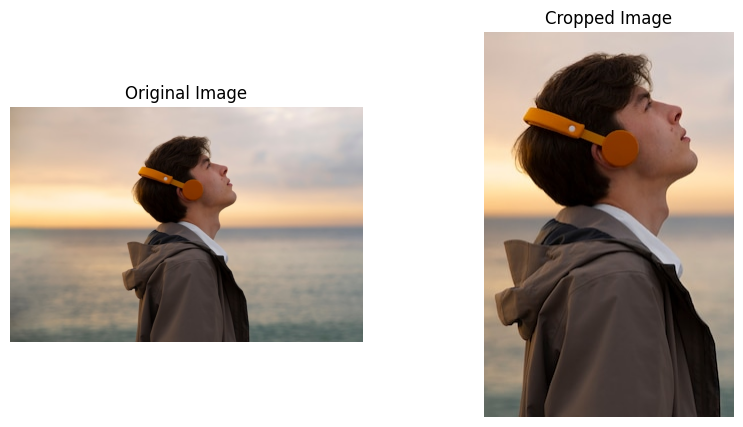

In [8]:
# Example usage
image_url = "https://img.freepik.com/free-photo/medium-shot-contemplative-man-seaside_23-2150531618.jpg"
#image_url = "https://img.freepik.com/free-photo/front-view-sad-girl-being-bullied-by-girls_23-2149748405.jpg"
original, cropped = detect_and_crop(image_url, 250, 400)

# Display both images in notebook
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(cropped)
axes[1].set_title("Cropped Image")
axes[1].axis("off")
plt.show()
